Install qiskit
and also matplotlib and pylatexenc (for nicer circuit plots)

In [205]:
!pip install qiskit 
!pip install qiskit_aer
!pip install qiskit_ibm_provider
!pip install qiskit_ibm_runtime
!pip install qiskit_ibmq_provider 
!pip install matplotlib  
!pip install pylatexenc 

### Import Qiskit

In [206]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
import matplotlib.pyplot as plt

## Conventional Quantum Circuits

#### Preparing Bell states

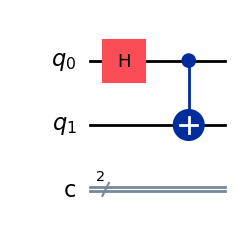

In [207]:
# Shortcut for QuantumCircuit(QuantumRegister(2), ClassicalRegister(2))
qc1 = QuantumCircuit(2,2)

# TODO prepare a Bell state
# e.g. by doing a h gate on qubit 0 followed by a cnot on qubits 0 and 1

qc1.h(0)
#qc1.p(np.pi/4, 0)
qc1.cx(0,1)

qc1.draw('mpl')

### Statevector

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


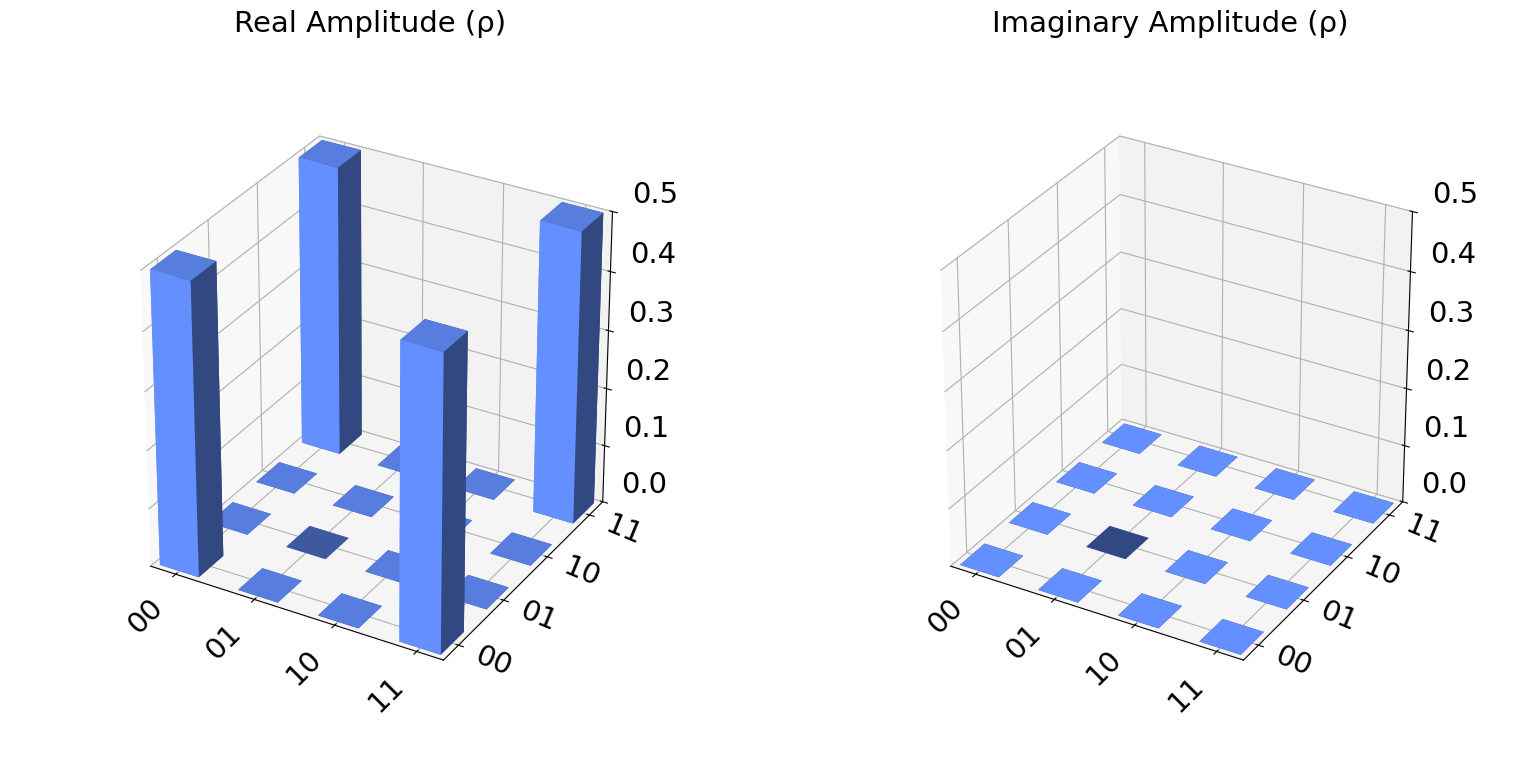

In [208]:

statevector_simulator = StatevectorSimulator()

#Transpile the circuit for the simulator
compiled_circuit = transpile(qc1, statevector_simulator)

# Execute the circuit on the simulator
job = statevector_simulator.run(compiled_circuit)
results1b = job.result()

# Get the statevector
statevector = results1b.get_statevector(qc1)
print(statevector)
plot_state_city(statevector)

### Quantum Measurement 


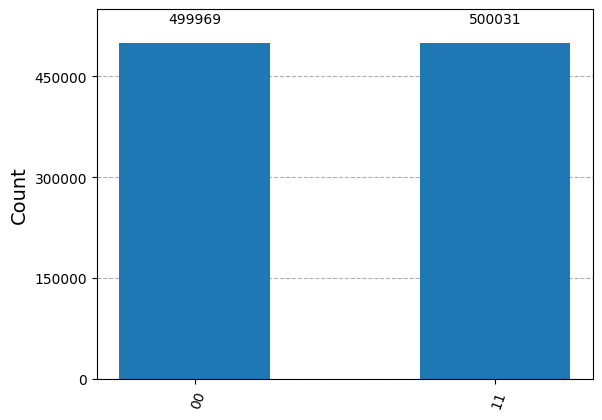

In [209]:
qc1.measure([0,1], [0,1])
# Shortcut:
#qc1.measure_all()

qc1.draw('mpl')

simulator = AerSimulator()
compiled_circuit = transpile(qc1, simulator)

# Execute the circuit on the simulator
job = simulator.run(compiled_circuit, shots=1000000)
results1b = job.result()
plot_histogram(results1b.get_counts())

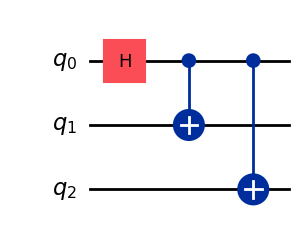

In [210]:
qc2 = QuantumCircuit(3)


# TODO implement a circuit that prepares 1/√2 (|0000⟩ + |1111⟩)

qc2.h(0)
qc2.cx(0,1)
qc2.cx(0,2)
#qc2.cx(0,3)


qc2.draw('mpl')

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


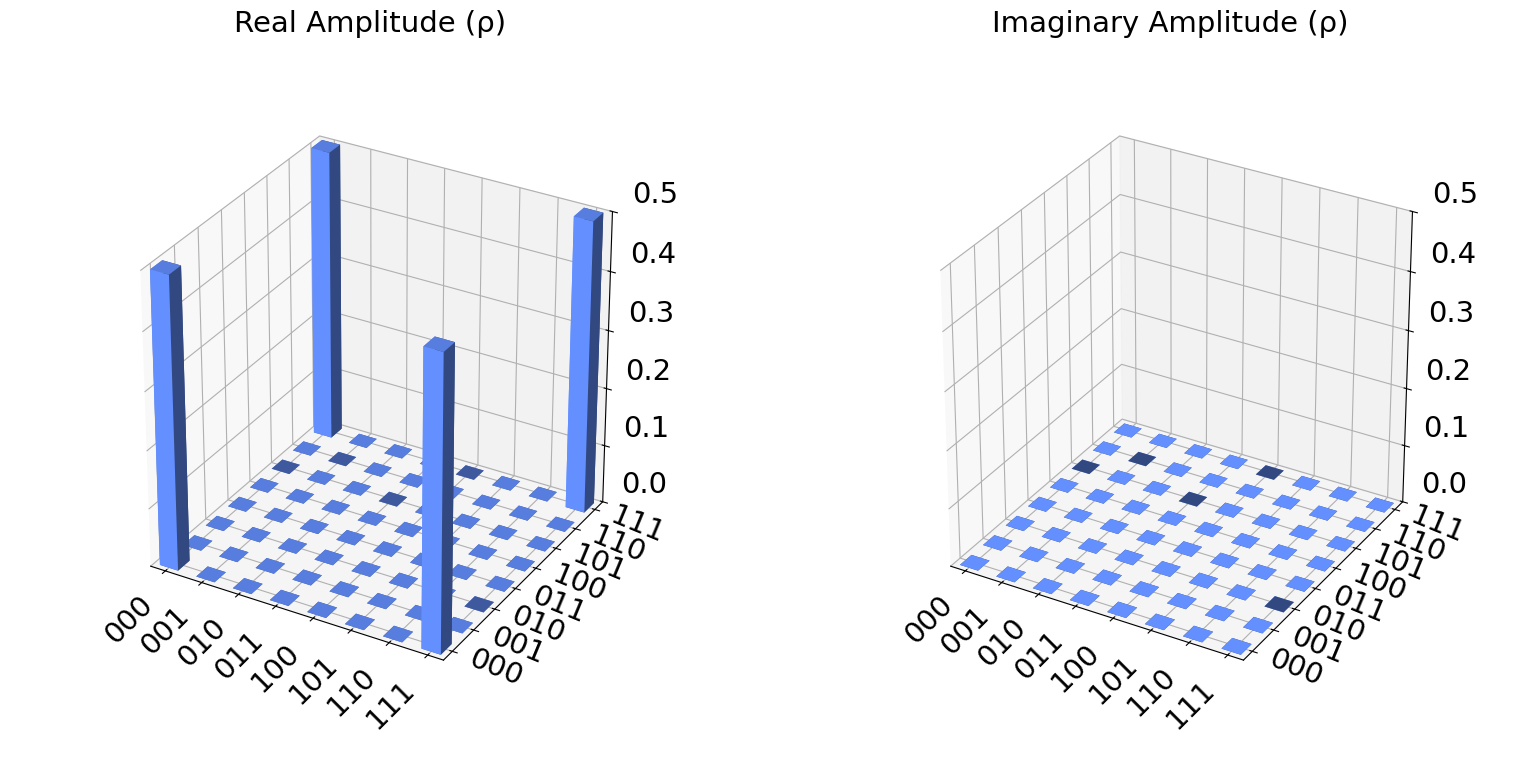

In [211]:

statevector_simulator = StatevectorSimulator()

#Transpile the circuit for the simulator
compiled_circuit = transpile(qc2, statevector_simulator)

# Execute the circuit on the simulator
job = statevector_simulator.run(compiled_circuit)
results2 = job.result()

# Get the statevector
statevector = results2.get_statevector(qc2)
print(statevector)
plot_state_city(statevector)

## Quantum Circuits and Quantum Entanglement Channels

### C_NOT

In [212]:

# Define the input states as functions of time
def psi_1_in(t):
    Omega_0 = 1500
    Omega_1 = 2*Omega_0
    return  np.array([0,1]) #1/np.sqrt(2)*np.array([1,1]) #1/np.sqrt(2) * np.array([np.exp(1j*Omega_0*t), np.exp(1j*Omega_1*t)])

def psi_2_in(t):
    Omega_0 = 1500
    Omega_1 = 2*Omega_0
    return np.array([1,0])#np.array([np.exp(-1j*Omega_0*t), np.exp(-1j*Omega_1*t)]) 

def cn(psi_1_in, psi_2_in, Omega):
    Omega_0 = Omega
    Omega_1 = 2 * Omega
    
    def psi_1_out(t):
        psi_1_in_t = psi_1_in(t)
        return np.array([
            psi_1_in_t[0] * np.exp(1j * Omega_0 * t),
            psi_1_in_t[1] * np.exp(1j * Omega_1 * t)
        ])

    def psi_2_out(t):
        psi_1_out_t = psi_1_out(t)
        psi_2_in_t = psi_2_in(t)
        return np.array([
            psi_2_in_t[0] * np.conjugate(psi_1_out_t[0]) + psi_2_in_t[1] * np.conjugate(psi_1_out_t[1]),
            psi_2_in_t[0] * np.conjugate(psi_1_out_t[1]) + psi_2_in_t[1] * np.conjugate(psi_1_out_t[0])
        ])
    
    return psi_1_out, psi_2_out

Omega_12 = 1000 # base frequency associated to entangled pair
psi_1_out, psi_2_out = cn(psi_1_in, psi_2_in,Omega_12)

#psi_1_out, psi_2_out = cn(psi_2_out, psi_1_out,Omega_12)

#psi_1_out, psi_2_out = cn(psi_1_out, psi_2_out,Omega_12)



# Define the time interval and number of points
t_start = 0
t_end = 0.5
num_points = 10000

# Create an array of time points
t_values = np.linspace(t_start, t_end, num_points)

alpha_t = np.array([[psi_1_out(ti)[0] * psi_2_out(ti)[0], 
                   psi_1_out(ti)[0] * psi_2_out(ti)[1], 
                   psi_1_out(ti)[1] * psi_2_out(ti)[0], 
                   psi_1_out(ti)[1] * psi_2_out(ti)[1]] for ti in t_values]) # 2 qubit temporal coefficients


#temporal_average = np.trapz(f_values, t, axis=0) / (t_end - t_start)
alpha = np.trapz(alpha_t, t_values, axis=0) / (t_end - t_start)

norm_squared = np.sum(np.abs(alpha)**2) # use this to normalize?

print("a_00 = ", np.round(alpha[0], 2))
print("a_01 = ", np.round(alpha[1], 2))
print("a_10 = ", np.round(alpha[2], 2))
print("a_11 = ", np.round(alpha[3], 2))
print("Norm squared:", norm_squared)


a_00 =  0j
a_01 =  0j
a_10 =  0j
a_11 =  (1+0j)
Norm squared: 1.0


### Plot

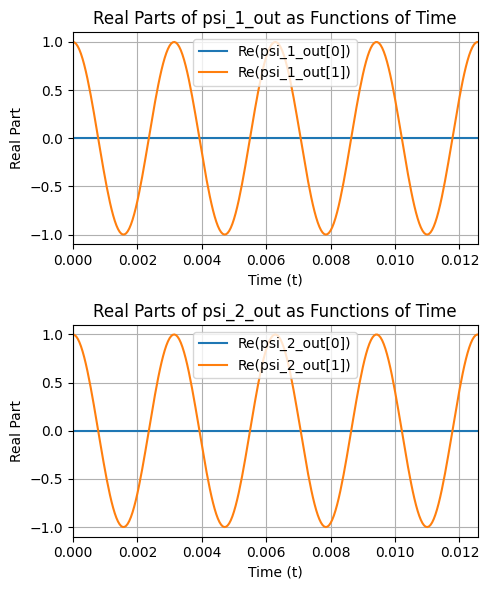

In [213]:

# Evaluate the functions at each time point
psi_1_out_values = np.array([psi_1_out(ti) for ti in t_values])
psi_2_out_values = np.array([psi_2_out(ti) for ti in t_values])

# Plot the real parts of psi_1_out and psi_2_out in separate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Plot for psi_1_out
ax1.plot(t_values, psi_1_out_values[:, 0].real, label='Re(psi_1_out[0])')
ax1.plot(t_values, psi_1_out_values[:, 1].real, label='Re(psi_1_out[1])')
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Real Part')
ax1.set_title('Real Parts of psi_1_out as Functions of Time')
ax1.legend()
ax1.grid(True)
ax1.set_xlim([0, 2 * (2 * np.pi / Omega_12)])

# Plot for psi_2_out
ax2.plot(t_values, psi_2_out_values[:, 0].real, label='Re(psi_2_out[0])')
ax2.plot(t_values, psi_2_out_values[:, 1].real, label='Re(psi_2_out[1])')
ax2.set_xlabel('Time (t)')
ax2.set_ylabel('Real Part')
ax2.set_title('Real Parts of psi_2_out as Functions of Time')
ax2.legend()
ax2.grid(True)
ax2.set_xlim([0, 2 * (2 * np.pi /Omega_12)])

plt.tight_layout()
plt.show()

## Experimental Implementation

In [232]:
# system frequency
omega_0 = 2 * np.pi * 500
omega_1 = 2 * omega_0

# quantum frequency
Omega_12_0 = 2 * np.pi *2000 # quantum res freq must be larger than twice envelope freq
Omega_12_1 =  Omega_12_0*2# does not have to be harmonic 

# time span
tspan = np.array([0, 5 * (2 * np.pi) / omega_0])  # [ti, tf] !!! Integer number of base frequencies

# time scale
t_s = 0.001 * (2 * np.pi) / Omega_12_0 # WHY NOT OMEGA_12_0???
f_s = 1 / t_s #sampling freq
t = np.arange(tspan[0], tspan[1] + t_s, t_s)  # ts must be smaller or equal to (2*pi)/omega_1_q (quantum time step) in order to observe mixed


# Entanglement channels (carrier)
ch_0 = 1  # DC "local entanglement"
ch_1 = np.exp(+1j* Omega_12_0 * t)
ch_2 = np.exp(+1j* Omega_12_1 * t)

# Temporal state representation (signal to transmit)
st_0 = np.exp(-1j * omega_0 * t)
st_1 = np.exp(-1j * omega_1 * t)

# Composite state normalization
nrm = (1 / np.sqrt(2)) ** (1 / 2)

#### State Initialization

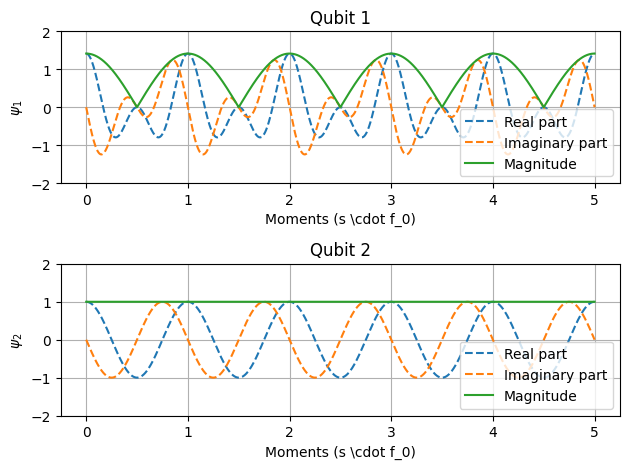

In [233]:
# Nonseparable state: modulate the coefficients to obtain a Bell state
# Random global phases
#psi_1_t_in = np.exp(+1j * (np.random.rand() - 0.5) * 2 * np.pi) * ((nrm * st_0) * ch_1 + (nrm * st_1) * ch_2)
#psi_2_t_in = np.exp(+1j * (np.random.rand() - 0.5) * 2 * np.pi) * ((nrm * st_0) * np.conj(ch_1) + (nrm * st_1) * np.conj(ch_2))

# Separable state (DC channel)
theta = np.pi/2
phi = 0

a1_t_in = ch_0*(np.cos(theta/2))
b1_t_in = ch_0*(np.exp(1j * phi) * np.sin(theta/2))
a2_t_in = ch_0
b2_t_in = 0

psi_1_t_in = a1_t_in * st_0  + b1_t_in * st_1
psi_2_t_in = a2_t_in * st_0  + b2_t_in * st_1

# Plot the results
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(t * omega_0/(2 * np.pi), np.real(psi_1_t_in), '--', label='Real part')
plt.plot(t * omega_0/(2 * np.pi), np.imag(psi_1_t_in), '--', label='Imaginary part')
plt.plot(t * omega_0/(2 * np.pi), np.abs(psi_1_t_in), '-', label='Magnitude')
plt.xlabel('Moments (s \\cdot f_0)')
plt.ylabel(r'$\psi_1$')
plt.ylim([-2, 2])
plt.grid(True)
plt.box(True)
plt.title('Qubit 1')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t * omega_0/(2 * np.pi), np.real(psi_2_t_in), '--', label='Real part')
plt.plot(t * omega_0/(2 * np.pi), np.imag(psi_2_t_in), '--', label='Imaginary part')
plt.plot(t * omega_0/(2 * np.pi), np.abs(psi_2_t_in), '-', label='Magnitude')
plt.xlabel('Moments (s \\cdot f_0)')
plt.ylabel(r'$\psi_2$')
plt.ylim([-2, 2])
plt.grid(True)
plt.box(True)
plt.title('Qubit 2')
plt.legend()

plt.tight_layout()
plt.show()

#### Readout

In [234]:
# ESTIMATE the coefs, alpha, from the measured data psi: (lockin) only possible bc in the state is spearable
a1_t_in_est = 1 / tspan[-1] * np.trapz(np.conj(st_0) * psi_1_t_in, t)
b1_t_in_est = 1 / tspan[-1] * np.trapz(np.conj(st_1) * psi_1_t_in, t)
a2_t_in_est = 1 / tspan[-1] * np.trapz(np.conj(st_0) * psi_2_t_in, t)
b2_t_in_est = 1 / tspan[-1] * np.trapz(np.conj(st_1) * psi_2_t_in, t)

print(f"a1_t_in_est: {a1_t_in_est:.3f}")
print(f"b1_t_in_est: {b1_t_in_est:.3f}")
print(f"a2_t_in_est: {a2_t_in_est:.3f}")
print(f"b2_t_in_est: {b2_t_in_est:.3f}")

# # Estimated individual static state: (get DC value)
#norm_a1_est = 1 / tspan[-1] * np.trapz(a1_t_in * np.conj(a1_t_in), t)  # wb1_state0
#norm_b1_est = 1 / tspan[-1] * np.trapz(b1_t_in * np.conj(a1_t_in), t)  # wb1_state1
#norm_a2_est = 1 / tspan[-1] * np.trapz(a2_t_in * np.conj(a1_t_in), t)  # wb2_state0
#norm_b2_est = 1 / tspan[-1] * np.trapz(b2_t_in * np.conj(a1_t_in), t)  # wb2_state1

# Estimated composite state on input
#norm_a_00 = np.linalg.norm(1 / tspan[-1] * np.trapz(a1_t_in_est * a2_t_in_est, t))
#norm_a_01 = np.linalg.norm(1 / tspan[-1] * np.trapz(a1_t_in_est * b2_t_in_est, t))
#norm_a_10 = np.linalg.norm(1 / tspan[-1] * np.trapz(b1_t_in_est * a2_t_in_est, t))
#norm_a_11 = np.linalg.norm(1 / tspan[-1] * np.trapz(b1_t_in_est * b2_t_in_est, t))


## TEST
# a1_t_in_est = a1_t_in
# b1_t_in_est = b1_t_in
# a2_t_in_est = a2_t_in
# b2_t_in_est = b2_t_in

a1_t_in_est: 0.707+0.000j
b1_t_in_est: 0.707+0.000j
a2_t_in_est: 1.000+0.000j
b2_t_in_est: 0.000+0.000j


#### CNOT

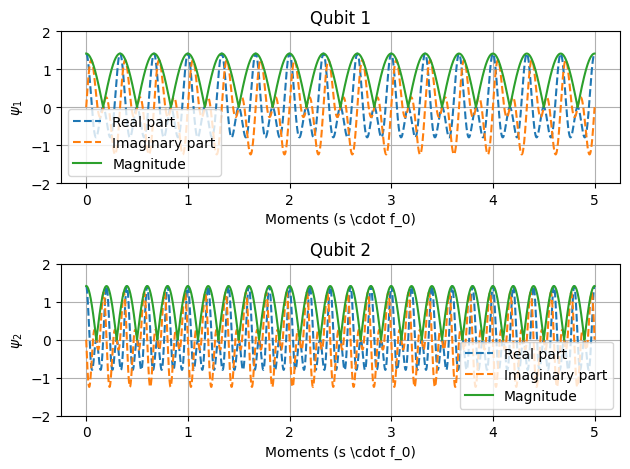

In [235]:

# Nonlinear CNOT operation
a1_t_out =  a1_t_in_est * ch_1 
b1_t_out =  b1_t_in_est * ch_2 

#a2_t_out = np.sqrt(2) * (a2_t_in_est * np.conj(a1_t_in_est * ch_1) + 1/2 * b2_t_in_est * np.conj(b1_t_in_est * ch_2))
#b2_t_out = np.sqrt(2) * (a2_t_in_est * np.conj(b1_t_in_est * ch_2) + 1/2 * b2_t_in_est * np.conj(a1_t_in_est * ch_1))

a2_t_out = (a2_t_in_est * np.conj(a1_t_in_est * ch_1) +  b2_t_in_est * np.conj(b1_t_in_est * ch_2))
b2_t_out = (a2_t_in_est * np.conj(b1_t_in_est * ch_2) +  b2_t_in_est * np.conj(a1_t_in_est * ch_1))


# OUTPUT STATE
psi_1_t_out = a1_t_out * st_0 + b1_t_out * st_1
psi_2_t_out = a2_t_out * st_0 + b2_t_out * st_1

# Plot the results
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(t * omega_0/(2 * np.pi), np.real(psi_1_t_out), '--', label='Real part')
plt.plot(t * omega_0/(2 * np.pi), np.imag(psi_1_t_out), '--', label='Imaginary part')
plt.plot(t * omega_0/(2 * np.pi), np.abs(psi_1_t_out), '-', label='Magnitude')
plt.xlabel('Moments (s \\cdot f_0)')
plt.ylabel(r'$\psi_1$')
plt.ylim([-2, 2])
plt.grid(True)
plt.box(True)
plt.title('Qubit 1')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t * omega_0/(2 * np.pi), np.real(psi_2_t_out), '--', label='Real part')
plt.plot(t * omega_0/(2 * np.pi), np.imag(psi_2_t_out), '--', label='Imaginary part')
plt.plot(t * omega_0/(2 * np.pi), np.abs(psi_2_t_out), '-', label='Magnitude')
plt.xlabel('Moments (s \\cdot f_0)')
plt.ylabel(r'$\psi_2$')
plt.ylim([-2, 2])
plt.grid(True)
plt.box(True)
plt.title('Qubit 2')
plt.legend()

plt.tight_layout()
plt.show()




#### Readout 

In [236]:
# Real composite state
alpha_00 = 1 / tspan[-1] * np.trapz(a1_t_out * a2_t_out, t)
alpha_01 = 1 / tspan[-1] * np.trapz(a1_t_out * b2_t_out, t)
alpha_10 = 1 / tspan[-1] * np.trapz(b1_t_out * a2_t_out, t)
alpha_11 = 1 / tspan[-1] * np.trapz(b1_t_out * b2_t_out, t)
print("\nReal composite state:")
print(f"alpha_00: {alpha_00:.3f}")
print(f"alpha_01: {alpha_01:.3f}")
print(f"alpha_10: {alpha_10:.3f}")
print(f"alpha_11: {alpha_11:.3f}")


# # ESTIMATOR METHOD (No bueno)
# a1_t_out_est = np.conj(st_0) * psi_1_t_out # NOT GOOD ESTIMATORS ( psi_1 = st_1, psi_2 = st_1 is wrong)
# b1_t_out_est = np.conj(st_1) * psi_1_t_out
# a2_t_out_est = np.conj(st_0) * psi_2_t_out
# b2_t_out_est = np.conj(st_1) * psi_2_t_out

# # Estimated composite state
# alpha_00_est = 1 / tspan[-1] * np.trapz(a1_t_out_est * a2_t_out_est, t)
# alpha_01_est = 1 / tspan[-1] * np.trapz(a1_t_out_est * b2_t_out_est, t)
# alpha_10_est = 1 / tspan[-1] * np.trapz(b1_t_out_est * a2_t_out_est, t)
# alpha_11_est = 1 / tspan[-1] * np.trapz(b1_t_out_est * b2_t_out_est, t)

# print("\nEstimated composite state:")
# print(f"alpha_00_est: {alpha_00_est:.3f}")
# print(f"alpha_01_est: {alpha_01_est:.3f}")
# print(f"alpha_10_est: {alpha_10_est:.3f}")
# print(f"alpha_11_est: {alpha_11_est:.3f}")


Real composite state:
alpha_00: 0.500-0.000j
alpha_01: 0.000+0.000j
alpha_10: 0.000+0.000j
alpha_11: 0.500-0.000j


In [237]:
# plt.figure(1)
# plt.plot(t,b1_t_out * a2_t_out)
# plt.xlabel('t')
# plt.ylabel('a1_t_out_est * b2_t_out_est')
# plt.grid(True)
# plt.show()